# Time Series Forecasting: Global Land Surface Temperature
**Author:** Kushal Kharel  

The dataset is the repackaged data put together by the Berkeley Earth which is affiliated with Lawrence Berkeley National Laboratory. The dataset has multiple features as below:

1) Date: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures.

2) LandAverageTemperature: global average land temperature in celsius

3) LandAverageTemperatureUncertainty: the 95% confidence interval around the average

4) LandMaxTemperature: global average maximum land temperature in celsius

5) LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature

6) LandMinTemperature: global average minimum land temperature in celsius

7) LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature

8) LandAndOceanAverageTemperature: global average land and ocean temperature in celsius

9) LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature

For this analysis, we will be only looking at date and Land Average Temperature. In other words, univariate time series.

The objective of this study is to forecast the future average land temperature using traditional statistical models and deep learning models and compare the predictive performance and determine which approach yields the most accurate long term temperature forecasts.

## Data Loading and Cleaning

In [170]:
!pip install pmdarima

In [171]:
# importing libraries
import sys
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np
import tensorflow as tf

from pprint import pprint

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [172]:
# check if GPU is available

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [173]:
# Set the path to the file you'd like to load
file_path = "GlobalTemperatures.csv"

# Load the latest version
df = kagglehub. dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "berkeleyearth/climate-change-earth-surface-temperature-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
  # Dataset Link: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
)

Using Colab cache for faster access to the 'climate-change-earth-surface-temperature-data' dataset.


In [174]:
# first few records of dataset

pprint(df.head(n=4).to_dict())

{'LandAndOceanAverageTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandAndOceanAverageTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandAverageTemperature': {0: 3.0340000000000003, 1: 3.083, 2: 5.626, 3: 8.49},
 'LandAverageTemperatureUncertainty': {0: 3.574, 1: 3.702, 2: 3.076, 3: 2.451},
 'LandMaxTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMaxTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMinTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMinTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'dt': {0: '1750-01-01', 1: '1750-02-01', 2: '1750-03-01', 3: '1750-04-01'}}


In [175]:
# subsetting only dt and LandAverageTemperature columns from the dataset

temp_df = df[['dt', 'LandAverageTemperature']]

In [176]:
# few data of subsetted dataset

pprint(temp_df.head(n=4).to_dict())

{'LandAverageTemperature': {0: 3.0340000000000003, 1: 3.083, 2: 5.626, 3: 8.49},
 'dt': {0: '1750-01-01', 1: '1750-02-01', 2: '1750-03-01', 3: '1750-04-01'}}


In [177]:
# renaming column names

temp_df = temp_df.rename(columns = {'dt': 'Date', 'LandAverageTemperature': 'avg_temp'})

In [178]:
# checking duplicate values

pprint(temp_df[temp_df.duplicated()].to_dict())

{'Date': {}, 'avg_temp': {}}


In [179]:
# checking null values

pprint(temp_df[temp_df.isnull().any(axis=1)].to_dict())

{'Date': {10: '1750-11-01',
          16: '1751-05-01',
          18: '1751-07-01',
          21: '1751-10-01',
          22: '1751-11-01',
          23: '1751-12-01',
          25: '1752-02-01',
          28: '1752-05-01',
          29: '1752-06-01',
          30: '1752-07-01',
          31: '1752-08-01',
          32: '1752-09-01'},
 'avg_temp': {10: nan,
              16: nan,
              18: nan,
              21: nan,
              22: nan,
              23: nan,
              25: nan,
              28: nan,
              29: nan,
              30: nan,
              31: nan,
              32: nan}}


In [180]:
# Dropping Null Values

temp_df = temp_df.dropna()

In [181]:
# setting index for time series

temp_df['Date'] = pd.to_datetime(temp_df['Date'])

temp_df = temp_df.set_index('Date').sort_index()


In [182]:
# only getting data from 1753

temp_df = temp_df['avg_temp']['1753-01-01':]

In [183]:
# information about the data

temp_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3156 entries, 1753-01-01 to 2015-12-01
Series name: avg_temp
Non-Null Count  Dtype  
--------------  -----  
3156 non-null   float64
dtypes: float64(1)
memory usage: 49.3 KB


In [184]:
# describe the data

pprint(temp_df.describe().to_dict())

{'25%': 4.312,
 '50%': 8.628499999999999,
 '75%': 12.549,
 'count': 3156.0,
 'max': 19.021,
 'mean': 8.379347275031686,
 'min': -2.08,
 'std': 4.3803266334795605}


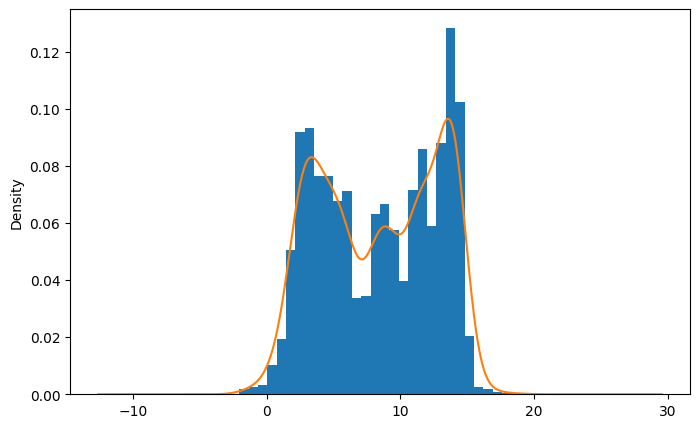

In [185]:
# look at the distribution of temperature

fig, ax = plt.subplots(figsize=(8,5))
temp_df.plot(kind='hist', ax=ax, density=True, bins=30)
temp_df.plot(kind='kde', ax=ax, label='Density')
plt.show()

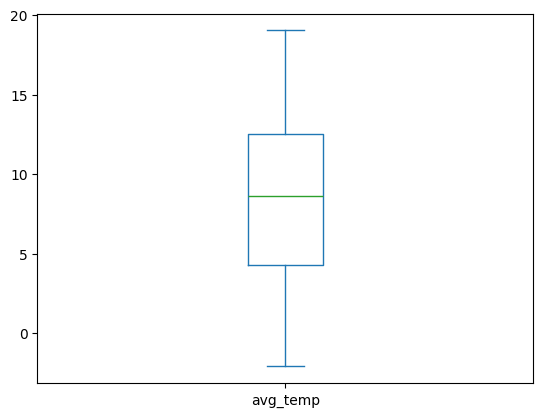

In [186]:
# box plot for temperature

temp_df.plot(kind='box')
plt.show()

In [187]:
pprint(temp_df.head().to_dict())

{Timestamp('1753-01-01 00:00:00'): 2.039,
 Timestamp('1753-02-01 00:00:00'): 0.7149999999999999,
 Timestamp('1753-03-01 00:00:00'): 5.424,
 Timestamp('1753-04-01 00:00:00'): 8.272,
 Timestamp('1753-05-01 00:00:00'): 12.186}


In [188]:
# temp_df = temp_df.asfreq("MS")   # Monthly Start frequency

In [189]:
# sort the series

temp_df = temp_df.sort_index()

In [190]:
# final values of series

pprint(temp_df.tail(n=4).to_dict())

{Timestamp('2015-09-01 00:00:00'): 12.999,
 Timestamp('2015-10-01 00:00:00'): 10.800999999999998,
 Timestamp('2015-11-01 00:00:00'): 7.433,
 Timestamp('2015-12-01 00:00:00'): 5.518}


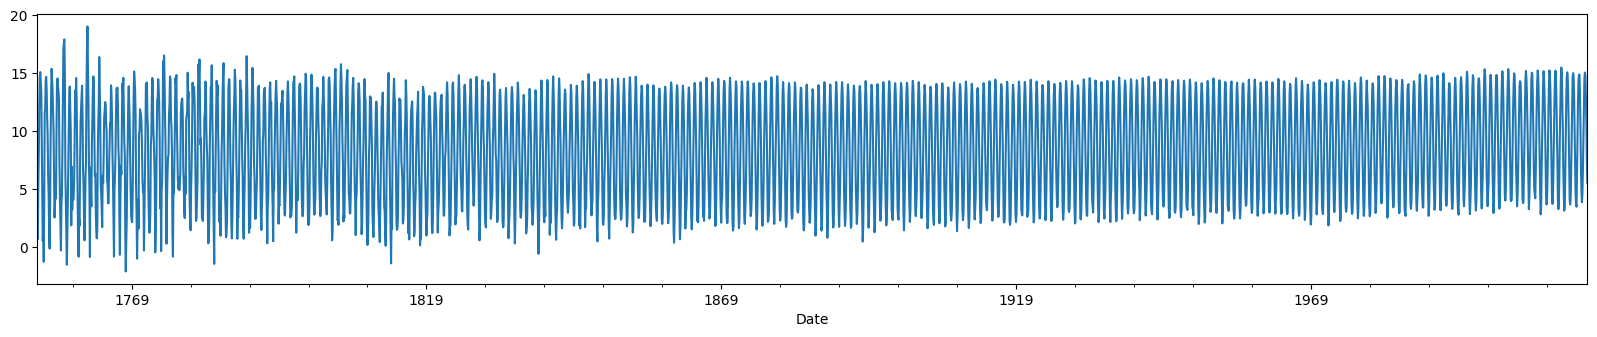

In [191]:
# average temperature plot


temp_df.plot(y='avg_temp', figsize=(20, 3.5))
plt.show()

<Axes: xlabel='Date'>

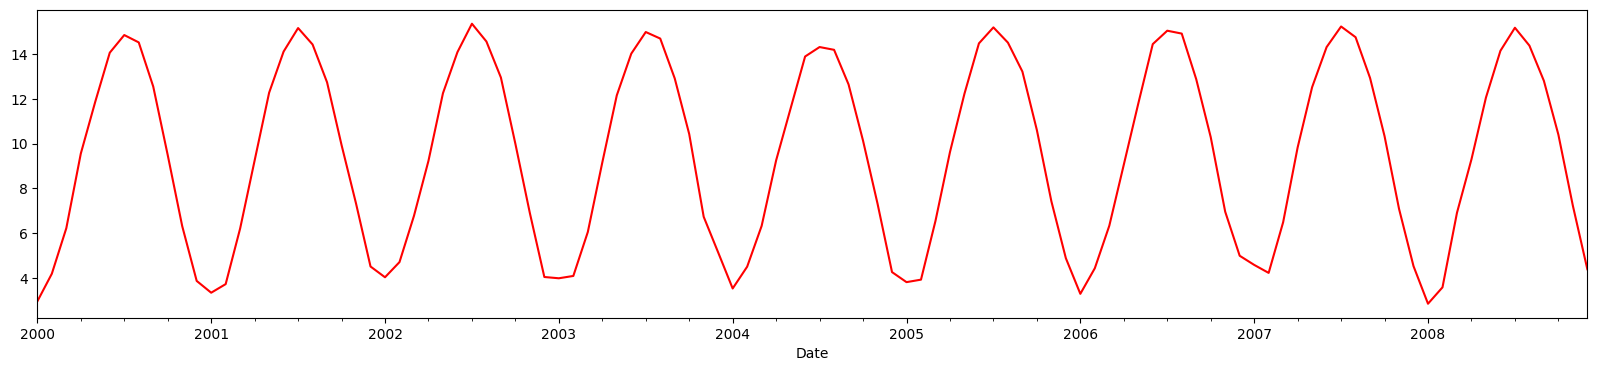

In [192]:
# average temperature subset plot

temp_df['2000-01-01':'2008-12-31'].plot(y = 'avg_temp', color='red', figsize=(20,4))

We can see from the plot above that there is a strong yearly seasonality. It is so strong that copying last year's value for this year will give us reasonable good solution. This **naive forecasting** will be one of our baseline.

We are shifting the data by 12 months.

In [193]:
n_periods = 12
y_true = temp_df[-n_periods:]
y_naive = temp_df[-2*n_periods:-n_periods] # The 12 months immediately preceding the validation set

mae_naive_12_step = mean_absolute_error(y_true, y_naive)
print("MAE Naive Forecast (12-step):", mae_naive_12_step)

MAE Naive Forecast (12-step): 0.38666666666666644


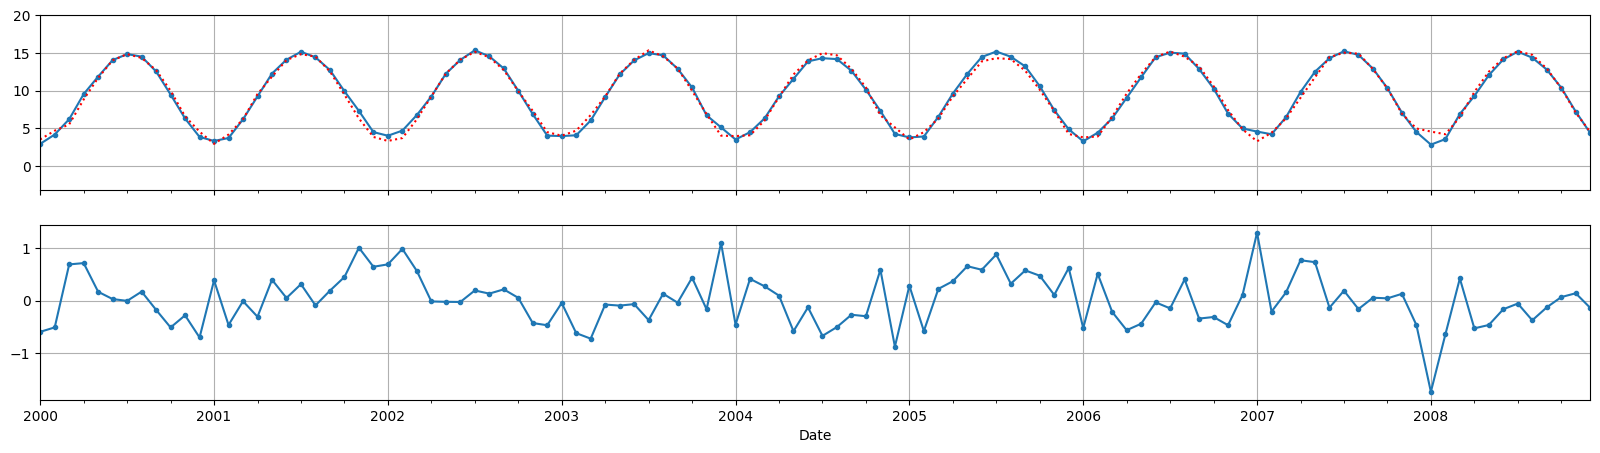

In [194]:
diff_year = temp_df.diff(12) # 12 month differenced series

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 5))

temp_df['2000-01-01':'2008-12-31'].plot(ax=axs[0], legend=False, marker='.') # original time series
temp_df.shift(12).plot(ax=axs[0], grid=True, legend=False, linestyle=':', color = 'red') # lagged series

diff_year['2000-01-01':'2008-12-31'].plot(ax=axs[1], grid=True, marker='.')
plt.show()

We can see from the plot above that lagged version of time series closely follows the original time series. We have autocorrelation here.

From the differenced series, we can see that we have removed seasonality from the dataset. Except for few like in 2008 there is a strong dip. Maybe something caused this.

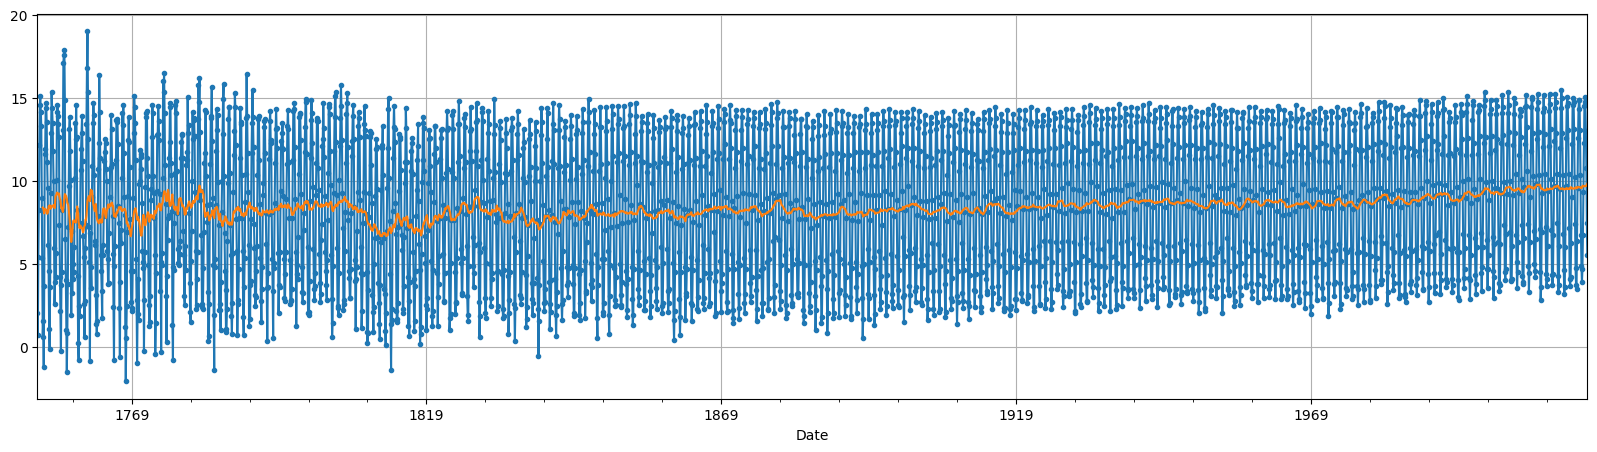

In [195]:
# rolling 12 month average to see the trend of Series

period = slice('1753', '2015')
rolling_average_12_months = temp_df[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(20,5))
temp_df[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

## Classical Statistical Model

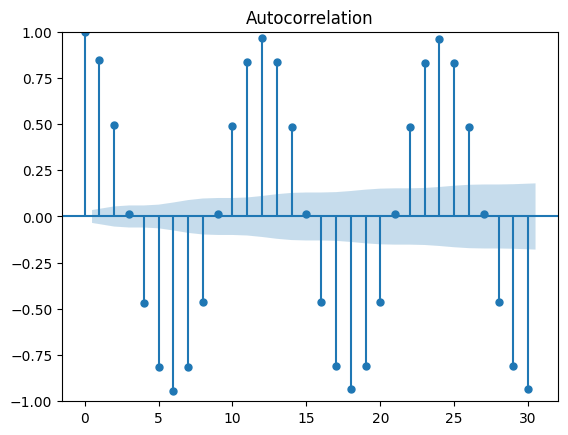

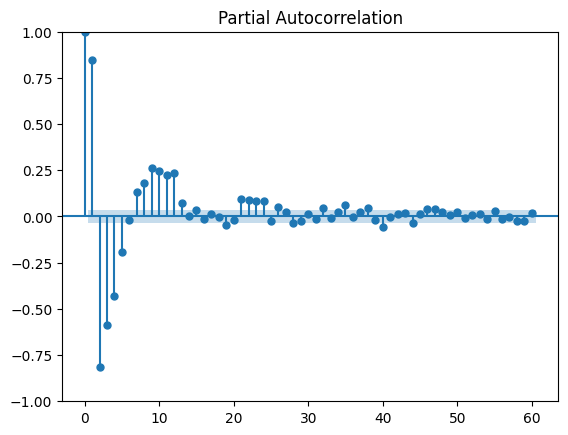

In [196]:
plot_acf(temp_df, lags=30)
plt.savefig('acf_original_series.jpeg')
plot_pacf(temp_df, lags=60)
plt.savefig('pacf_original_series.jpeg')
plt.show()

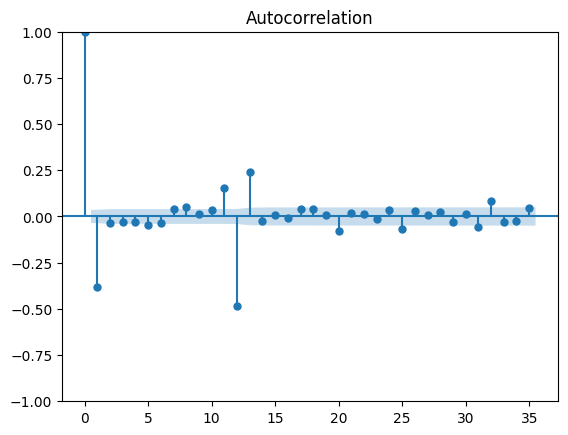

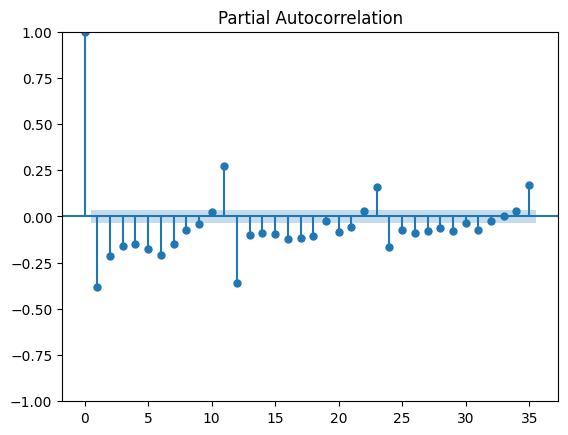

In [197]:
# differenced series pacf and acf

plot_acf(temp_df.diff(1).dropna().diff(12).dropna())
plt.savefig('acf_diff_series.jpeg')
plot_pacf(temp_df.diff(1).dropna().diff(12).dropna())
plt.savefig('pacf_diff_series.jpeg')
plt.show()


The initial inspection of the ACF and PACF plots for the original time series immediately identified two clear issues: non-stationarity and strong seasonality at lag 12. The slow, gradual decay in the ACF confirmed the presence of a trend, requiring a first-order non-seasonal differencing ($\mathbf{d=1}$). The large, significant spikes at every 12th lag in both the ACF and PACF plots confirmed a strong yearly cycle, necessitating a first-order seasonal differencing ($\mathbf{D=1}$) at a seasonal period of $s=12$.

After applying both non-seasonal and seasonal differencing ($\nabla\nabla_{12}Y_t$), the series was rendered stationary.  The plots for this fully differenced series were then used to determine the specific AR/MA orders:

Seasonal Orders ($P, Q$): The large, isolated, and significant spikes remaining at Lag 12 in both the ACF and PACF plots strongly suggested the need for both a seasonal autoregressive term ($\mathbf{P=1}$) and a seasonal moving average term ($\mathbf{Q=1}$).

Non-Seasonal Orders ($p, q$): The PACF plot showed significant spikes at Lags 1 and 2, suggesting $p=2$, while the ACF plot also showed significant spikes at Lags 1 and 2, suggesting $q=2$. To maintain parsimony (model simplicity), we chose the simplest non-seasonal order $\mathbf{(1, 1, 1)}$

The final, fully diagnosed SARIMA model order is:$$\text{SARIMA}(1, 1, 1) \times (1, 1, 1)_{12}$$

In [198]:
# Lets remove trend and seasonality, to make our dataset stationary

# remove trend
temp_df_diff_1 = temp_df.diff(1).dropna()
# remove seasonality
temp_df_diff_2 = temp_df_diff_1.diff(12).dropna()

<Axes: xlabel='Date'>

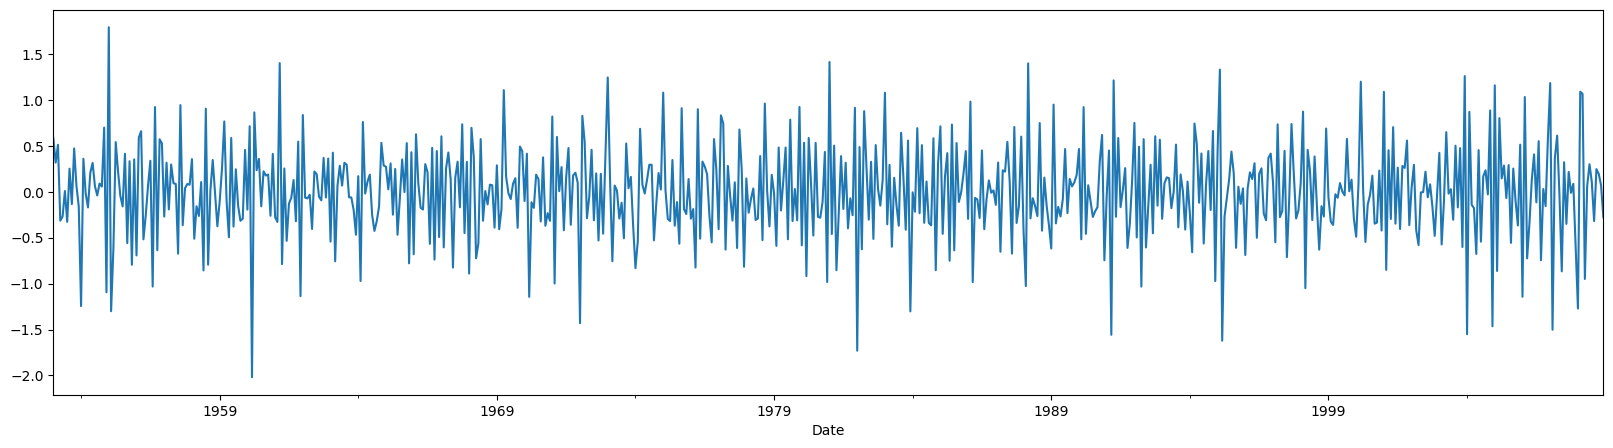

In [199]:
# verify time series is stationary

temp_df_diff_2['1953-01-01':'2008-12-31'].plot(figsize=(20,5))

### ARIMA and Auto ARIMA Model

Fitting ARIMA model

ARIMA has (p, d, q):

p → AR (autoregressive) order (how many past months to use)

d → differencing order (to remove trend)

q → MA (moving average) order (how many past errors to use)

Seasonal part (P, D, Q, s):

P → seasonal AR (how many past years to use)

D → seasonal differencing → we differenced 12 → D=1

Q → seasonal MA

s → seasonal period → 12 months

In [292]:
# model training
data_to_fit_arima = temp_df['1753-01':'2013-12']
model = ARIMA(data_to_fit_arima.asfreq('MS'), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

In [293]:
# 12 step ahead forecast

n_periods = 12
y_pred = results.get_forecast(steps=n_periods).predicted_mean
print(y_pred)

2014-01-01     3.723031
2014-02-01     4.250443
2014-03-01     6.337088
2014-04-01     9.415745
2014-05-01    12.248873
2014-06-01    14.410470
2014-07-01    15.253667
2014-08-01    14.786013
2014-09-01    13.005074
2014-10-01    10.331529
2014-11-01     7.096788
2014-12-01     4.676453
Freq: MS, Name: predicted_mean, dtype: float64


In [294]:
# trying auto arima and see what stepwise search finds us in the search space

auto_model = auto_arima(data_to_fit_arima.asfreq('MS'),
                        seasonal=True,
                        m=12,
                        start_p=0,
                        start_q=0,
                        max_p=2,
                        max_q=3,
                        start_P=0,
                        start_Q=0,
                        max_P=2,
                        max_Q=2,
                        d=1,
                        D=1,
                        trace=True,
                        stepwise=True
                        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=10237.904, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8939.612, Time=1.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=9746.669, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8689.398, Time=2.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.55 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=9155.938, Time=1.96 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8534.689, Time=3.12 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=8790.667, Time=1.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.37 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.16 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=19.43 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=20.52 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=8536.68

In [295]:
print(auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3132
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -4262.344
Date:                            Tue, 25 Nov 2025   AIC                           8534.689
Time:                                    09:39:22   BIC                           8564.915
Sample:                                01-01-1753   HQIC                          8545.539
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.010    -46.741      0.000      -0.476      -0.438
ar.L2         -0.2215      0.009   

In [296]:
# 12 step ahead forecast with auto arima

n_periods = 12
y_pred_auto, conf_interval = auto_model.predict(n_periods=n_periods, return_conf_int=True)
print(y_pred_auto)


2014-01-01     3.637215
2014-02-01     4.173762
2014-03-01     6.433586
2014-04-01     9.662110
2014-05-01    12.554216
2014-06-01    14.774596
2014-07-01    15.450044
2014-08-01    15.098401
2014-09-01    13.334439
2014-10-01    10.627676
2014-11-01     7.448421
2014-12-01     4.784039
Freq: MS, dtype: float64


In [298]:
y_true = temp_df['2014-01':'2014-12']
pprint(y_true.to_dict())

{Timestamp('2014-01-01 00:00:00'): 3.732,
 Timestamp('2014-02-01 00:00:00'): 3.5,
 Timestamp('2014-03-01 00:00:00'): 6.377999999999999,
 Timestamp('2014-04-01 00:00:00'): 9.589,
 Timestamp('2014-05-01 00:00:00'): 12.582,
 Timestamp('2014-06-01 00:00:00'): 14.335,
 Timestamp('2014-07-01 00:00:00'): 14.873,
 Timestamp('2014-08-01 00:00:00'): 14.875,
 Timestamp('2014-09-01 00:00:00'): 13.091,
 Timestamp('2014-10-01 00:00:00'): 10.33,
 Timestamp('2014-11-01 00:00:00'): 6.712999999999999,
 Timestamp('2014-12-01 00:00:00'): 4.85}


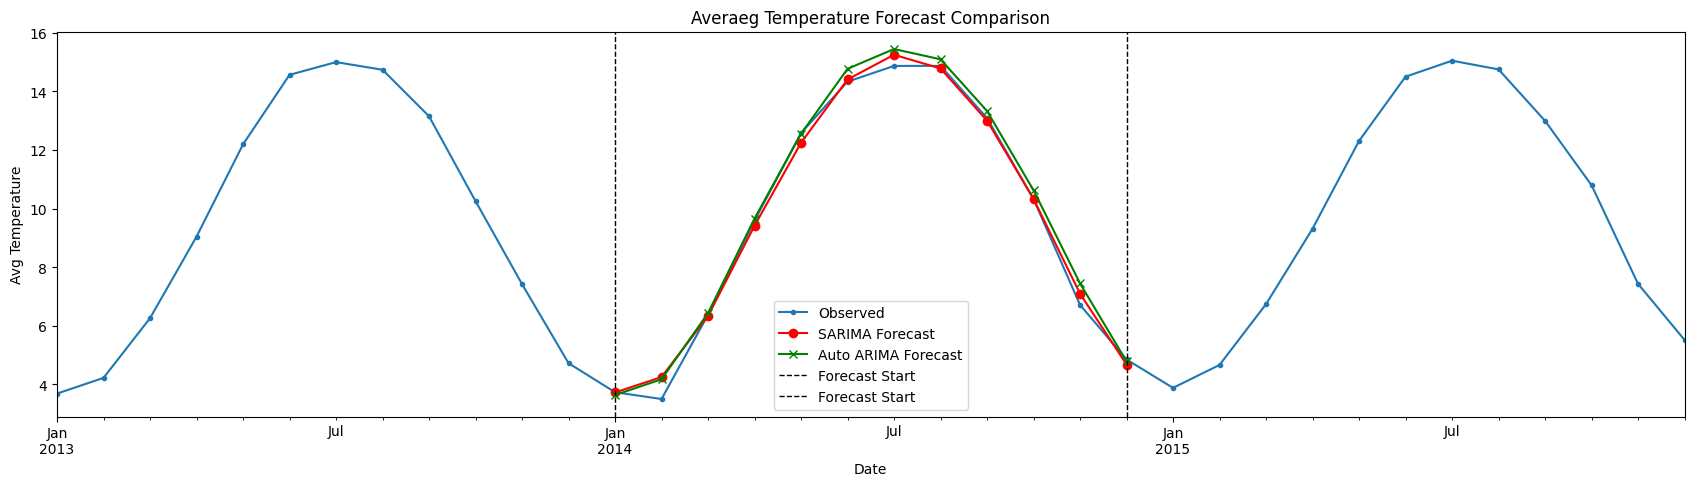

In [301]:
start_date, end_date = '2013-01-01', '2015-12-31'
time_period = pd.date_range(start_date, end_date, freq='MS')

fig, ax = plt.subplots(figsize=(21, 5))
temp_df.loc[time_period].plot(ax=ax, marker='.', label='Observed', grid=True)
y_pred.plot(ax=ax, marker='o', color='r', label='SARIMA Forecast')
y_pred_auto.plot(ax=ax, marker='x', color='g', label='Auto ARIMA Forecast')
ax.axvline(pd.Timestamp('2014-01-01'), linestyle='--', color='k', linewidth=1, label='Forecast Start')
ax.axvline(pd.Timestamp('2014-12-31'), linestyle='--', color='k', linewidth=1, label='Forecast Start')
plt.title("Averaeg Temperature Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Avg Temperature")
plt.legend()
plt.show()


In [311]:
mae_manual = mean_absolute_error(y_true, y_pred)
mae_auto = mean_absolute_error(y_true, y_pred_auto)

print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("MAE Naive Forecast:", mae_naive_12_step)

MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
MAE Naive Forecast: 0.38666666666666644


## Neural Network Models

In [208]:
# train, test and valid split

In [209]:
temp_df.head()

,avg_temp
Date,
1753-01-01,2.039
1753-02-01,0.715
1753-03-01,5.424
1753-04-01,8.272
1753-05-01,12.186


In [312]:
# We need to split before differencing since first row of each split depends on a value from the previous split.

temp_train_raw = temp_df['1753-01':'1997-12']
temp_valid_raw = temp_df['1998-01':'2014-12']
temp_test_raw = temp_df['2015-01':]

In [313]:
# function to temporiraly include 12 months of data from before the split only to compute the differences then drop it after diffencing to handle zero leakage4


def difference_with_history(raw_split, full_series, lags=(1,12)):
  # How many past points needed?
  required_history = max(lags) + 1 # for (1, 12): 12 months
  split_start = pd.to_datetime(raw_split.index[0])
  history_start = split_start - pd.DateOffset(months=required_history)
  extended = full_series.loc[history_start:raw_split.index[-1]] # pull needed history from the full raw series
  # applying differencing in order
  diffed = extended.copy()
  for lag in lags:
    diffed = diffed.diff(lag)
  diffed = diffed.dropna() # drop NaNs from differencing
  diffed = diffed.loc[diffed.index >= split_start] # keep only rows that belong in the split

  return diffed

In [314]:
# differenced series
temp_train_diff = difference_with_history(temp_train_raw, temp_df)
temp_valid_diff = difference_with_history(temp_valid_raw, temp_df)
temp_test_diff = difference_with_history(temp_test_raw, temp_df)

In [315]:
# min max scaled series

scaler = MinMaxScaler()
temp_train_scaled = scaler.fit_transform(temp_train_diff.values.reshape(-1,1))
temp_valid_scaled = scaler.transform(temp_valid_diff.values.reshape(-1,1))
temp_test_scaled = scaler.transform(temp_test_diff.values.reshape(-1,1))


In [316]:
temp_train = pd.DataFrame(temp_train_scaled, index=temp_train_diff.index, columns=['diff_temp_scaled'])
temp_valid = pd.DataFrame(temp_valid_scaled, index=temp_valid_diff.index, columns=['diff_temp_scaled'])
temp_test = pd.DataFrame(temp_test_scaled, index=temp_test_diff.index, columns=['diff_temp_scaled'])


In [317]:
# check the train differencing

temp_train.head().to_dict()

{'diff_temp_scaled': {Timestamp('1754-02-01 00:00:00'): 0.4163658243080627,
  Timestamp('1754-03-01 00:00:00'): 0.506147648197562,
  Timestamp('1754-04-01 00:00:00'): 0.7608434050122954,
  Timestamp('1754-05-01 00:00:00'): 0.3070684874169415,
  Timestamp('1754-06-01 00:00:00'): 0.4975671009260713}}

In [318]:
# check the valid differencing

temp_valid.head().to_dict()

{'diff_temp_scaled': {Timestamp('1998-01-01 00:00:00'): 0.49976455815413606,
  Timestamp('1998-02-01 00:00:00'): 0.5404698372835244,
  Timestamp('1998-03-01 00:00:00'): 0.43991000889446974,
  Timestamp('1998-04-01 00:00:00'): 0.5186522262334539,
  Timestamp('1998-05-01 00:00:00'): 0.5068801339402502}}

In [319]:
# check the test differencing

temp_test.head().to_dict()

{'diff_temp_scaled': {Timestamp('2015-01-01 00:00:00'): 0.49599748862031084,
  Timestamp('2015-02-01 00:00:00'): 0.5478993355307906,
  Timestamp('2015-03-01 00:00:00'): 0.4528331502118978,
  Timestamp('2015-04-01 00:00:00'): 0.4614136974833883,
  Timestamp('2015-05-01 00:00:00'): 0.4951080416470465}}

In [218]:
temp_train.shape, temp_valid.shape, temp_test.shape

((2927, 1), (204, 1), (12, 1))

In [219]:
# From 2015 to 2025 data is missing here (....)

In [320]:
# preparing dataset for Sequence to Vector One Step Forecast Models

# creating training dataset

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data = temp_train[:-12].to_numpy(),
    targets=temp_train[12:],# shift the target forward by 12 months; the model predicts the temperature 12 months after the end of each 12-month input window
    sequence_length = 12, # each input sample will be a consecutive 12 months differenced temperature
    batch_size = 10, # create batches of size 10 that is each batch gets 10 inputs sequence with each input sequence having 12 months of temperature values
    shuffle=True,
    seed=42
)

In [321]:
pprint(temp_train.head(n=10).to_dict()) # to see shuffle effect

{'diff_temp_scaled': {Timestamp('1754-02-01 00:00:00'): 0.4163658243080627,
                      Timestamp('1754-03-01 00:00:00'): 0.506147648197562,
                      Timestamp('1754-04-01 00:00:00'): 0.7608434050122954,
                      Timestamp('1754-05-01 00:00:00'): 0.3070684874169415,
                      Timestamp('1754-06-01 00:00:00'): 0.4975671009260713,
                      Timestamp('1754-07-01 00:00:00'): 0.4835975514048031,
                      Timestamp('1754-08-01 00:00:00'): 0.4853241249411397,
                      Timestamp('1754-09-01 00:00:00'): 0.4110291424684771,
                      Timestamp('1754-10-01 00:00:00'): 0.6419714330560353,
                      Timestamp('1754-11-01 00:00:00'): 0.5046303563019935}}


In [322]:
# visualizing first two batches of data

for i, (x, y) in enumerate(train_ds):
    print(f"Batch {i}")
    print("X (inputs):\n", x.numpy())
    print("Y (targets):\n", y.numpy())
    print("-"*30)
    if i == 1:  # stop after 2 batches
        break

Batch 0
X (inputs):
 [[[0.51274002]
  [0.48228954]
  [0.50206666]
  [0.50803118]
  [0.46005337]
  [0.44163658]
  [0.57981479]
  [0.45393188]
  [0.52289018]
  [0.4767959 ]
  [0.51075184]
  [0.48872495]]

 [[0.53978967]
  [0.47261027]
  [0.50965312]
  [0.46209386]
  [0.49536964]
  [0.47590645]
  [0.50196202]
  [0.50332235]
  [0.49306755]
  [0.50531052]
  [0.49735782]
  [0.50578141]]

 [[0.4240046 ]
  [0.561398  ]
  [0.53215089]
  [0.43708471]
  [0.51818134]
  [0.42792863]
  [0.4770575 ]
  [0.46361115]
  [0.5311568 ]
  [0.41641814]
  [0.48328363]
  [0.6049809 ]]

 [[0.48443468]
  [0.52943023]
  [0.44393868]
  [0.51771046]
  [0.56438026]
  [0.40998273]
  [0.48061529]
  [0.49123633]
  [0.50180505]
  [0.51771046]
  [0.50531052]
  [0.46287867]]

 [[0.45162978]
  [0.5311568 ]
  [0.51546068]
  [0.49463716]
  [0.48909119]
  [0.49338147]
  [0.49060849]
  [0.47302883]
  [0.5055198 ]
  [0.49777638]
  [0.49573589]
  [0.47836551]]

 [[0.45832679]
  [0.53842934]
  [0.48882959]
  [0.5072987 ]
  [0.5034

In [323]:
# creating validation dataset

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    temp_valid[:-12].to_numpy(),
    targets=temp_valid[12:],
    sequence_length = 12,
    batch_size = 5,
    shuffle=False,
    seed=42
)

In [324]:
for i, (x, y) in enumerate(valid_ds):
    print(f"Batch {i}")
    print("X (inputs):\n", x.numpy())
    print("Y (targets):\n", y.numpy())
    print("-"*30)
    if i == 1:  # stop after 2 batches
        break


Batch 0
X (inputs):
 [[[0.49976456]
  [0.54046984]
  [0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]]

 [[0.54046984]
  [0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]]

 [[0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]]

 [[0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]
  [0.47590645]]

 [[0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]
  [0.47590645]
  [0.49338147]]]
Y (targets):
 [[0.49165489]
 [0.47784231]
 [0.47590645]
 [0.49338147]

In [225]:
# One-step-Forecasts (Sequence to Vector Models)

### Linear Model - Sequence to Vector - One Step Forecast

In [325]:
# creating a linear model

tf.random.set_seed(42)

linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[12]), #shape: the model expects 1D vector of length 12 i.e, sequence length fixed at 12
    tf.keras.layers.Dense(1)
])

# simple sequence-to-vector model for a fixed-length input


In [326]:
print(linear_model.summary())

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [327]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = "val_mae",
    patience = 20,
    min_delta = 0.0001,
    restore_best_weights = True
)

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

linear_model.compile(loss = tf.keras.losses.Huber(),
                     optimizer=opt,
                     metrics=['mae']
                     )

linear_history = linear_model.fit(train_ds,
                                  validation_data=valid_ds,
                                  epochs=500,
                                  callbacks=[early_stopping_cb]
                                  )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2222 - mae: 0.6353 - val_loss: 0.0129 - val_mae: 0.1559
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - mae: 0.1132 - val_loss: 7.8640e-04 - val_mae: 0.0326
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - mae: 0.0621 - val_loss: 7.5639e-04 - val_mae: 0.0321
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - mae: 0.0614 - val_loss: 7.5171e-04 - val_mae: 0.0320
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - mae: 0.0612 - val_loss: 7.4099e-04 - val_mae: 0.0318
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0043 - mae: 0.0609 - val_loss: 7.3092e-04 - val_mae: 0.0316
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - mae: 0.0609 - val_loss: 7.1651e-04 - val_mae: 0.0313
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0043 - mae: 0.0604 - val_loss: 7.0580e-04 - val_mae: 0.0311
Epoch 9/500
291/291 

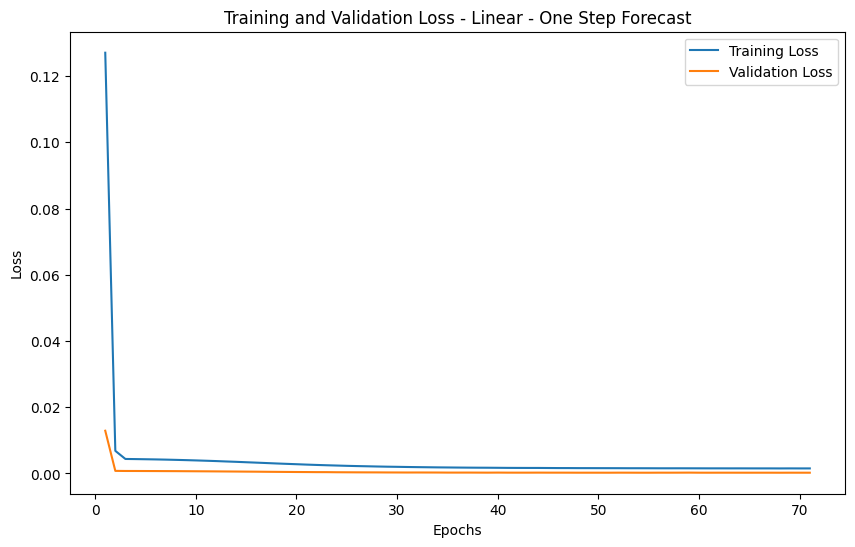

In [328]:
# linear model loss plot

linear_train_loss = linear_history.history['loss']
linear_val_loss = linear_history.history['val_loss']
epochs = range(1, len(linear_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, linear_train_loss, label='Training Loss')
plt.plot(epochs, linear_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Linear - One Step Forecast')
plt.legend()
# plt.show()
plt.savefig('linear.jpeg')

The loss plot for the linear model clearly shows that the validation loss (orange line) is consistently lower and parallel to the training loss (blue line). This is a great sign! It means our simple model is generalizing perfectly and has successfully captured the main, easy-to-find patterns in differenced and scaled temperature data without trying to memorize any specific noise from the training examples (which is called overfitting).

In [230]:
min(linear_history.history['val_mae'])
# this is in different scale than naive forecast and ARIMA AUTO ARIMA. Hence we need to inverse transform

0.01692313887178898

In [329]:
y_pred_scaled = linear_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_linear = mean_absolute_error(y_val, y_pred)
print("MAE Linear (One Step Forecast Error)", mae_linear)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE Linear (One Step Forecast Error) 0.3207811973512697


The above sliding window (sequence to vector, one step forecast) model has no recurrent or convolution processing, the model just learns a linear (or non linear if we add activations) mapping from a fixed-length input sequence to one output.

Input: $[t-11, t-10, ..., t]$ -> 12 numbers

Dense layer does not know that $t-11$ comes before $t-10$ and so on.

It just applies a linear combination of all the 12 numbers (each multiplied by the weight) plus a bias, and outputs 1 number.

Mathematically,

$$
y_{pred} = w_1x_1 + w_2x_2+...+w_{12}x_{12} + b
$$

where

$x_1 = t-11, x_2=t-10, ..., x_{12} = t$

The dense layer treats all inputs equally, it does not know the order matters.

Dense layer treats input as a simple 12-element vector, no temporal dynamics.It takes the entire 12-step input vector and maps it to a single scalar output, the predicted value for the next month.

In [330]:
# RECURSIVE PREDICTION (ROLL FORWARD) LOGIC ---

# 3a. Recursive Function
def perform_recursive_forecast(model, initial_window: np.ndarray,
                                true_future_values: np.ndarray, steps: int = 12) -> tuple:
    """
    Implements the 'roll forward' strategy for multi-step forecasting.
    Returns both the scaled predictions and the MAE.
    """

    forecasted_sequence = []
    current_input = initial_window.copy()

    # The model expects input shape (batch_size, sequence_length) -> (1, 12)
    # We flatten the last dimension if it exists, as the linear model expects (1, 12)
    if current_input.ndim == 3 and current_input.shape[2] == 1:
        current_input = current_input.reshape(current_input.shape[0], current_input.shape[1])

    for _ in range(steps):
        # 1. Predict one step (output shape is (1, 1))
        prediction = model.predict(current_input, verbose=0)

        # 2. Store the prediction (extract the single value)
        forecasted_sequence.append(prediction[0, 0])

        # 3. Roll the window forward (Discard oldest, add prediction)
        # Shift all elements one step to the left
        current_input = np.roll(current_input, shift=-1, axis=1)

        # Replace the last element (which is a duplicate due to roll) with the new prediction
        current_input[0, -1] = prediction[0, 0]

    # 4. Final Evaluation (Scaled)
    y_pred_recursive_scaled = np.array(forecasted_sequence).reshape(-1, 1)

    # Ensure true_future_values is flattened before comparison
    mae_scaled = mean_absolute_error(true_future_values.flatten(), y_pred_recursive_scaled.flatten())

    return y_pred_recursive_scaled, mae_scaled

In [331]:
# Get the last input sequence from the validation data
# valid_ds is a Keras dataset; we need to extract the raw features used to create it.
X_valid_raw = temp_valid[:-12].to_numpy()

initial_window_scaled = temp_valid.iloc[-2 * 12 : -12].to_numpy().reshape(1, 12)

# Get the 12 true future values that follow the initial window
# The validation set spans '1998-01' to '2014-12'. The true 12 steps start 12 months after
# the end of X_valid_raw. The last point of X_valid_raw is at temp_valid[:-12]
# The true future values are the last 12 points of the temp_valid data.
true_future_scaled = temp_valid.iloc[-12:].values.reshape(-1, 1)


# Recursive Forecast
y_pred_recursive_scaled, mae_scaled_recursive = perform_recursive_forecast(
    model=linear_model,
    initial_window=initial_window_scaled,
    true_future_values=true_future_scaled,
    steps=12
)

# Inverse Transform and Final MAE

# Inverse transform the true future values and predictions to the original temperature scale.
y_true_recursive_original = scaler.inverse_transform(true_future_scaled)
y_pred_recursive_original = scaler.inverse_transform(y_pred_recursive_scaled)

# Calculate the final MAE on the original (unscaled) temperature data.
final_recursive_mae_linear = mean_absolute_error(
    y_true_recursive_original,
    y_pred_recursive_original
)

print(f"\n--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---")
print(f"Initial Window Start Date: {temp_valid.index[-(12 * 2)]}")
print(f"Forecast Horizon Start Date: {temp_valid.index[-12]}")


--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---
Initial Window Start Date: 2013-01-01 00:00:00
Forecast Horizon Start Date: 2014-01-01 00:00:00


In [332]:
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (linear model): 0.3559401672904692
MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
Naive Forecast: 0.38666666666666644


### Simple Recurrent Neural Network - Sequence to Vector - One Step Forecast

In [333]:
# creating RNN model - sequence to vector - one step forecas

tf.random.set_seed(42)

rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]), # variable sequence length, 1 feature (dimension 1 feature since we are predicting univariate time series)
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=False), # default activation
    tf.keras.layers.Dense(1, activation=None)
])

# Input: a sequence of shape [[t1], [t2], ..., [t12]] (one time series value per timestep from the sequence)
# RNN layer outputs only the **last hidden state** (h12), not all hidden states.
# Dense layer is applied to this last hidden state to produce a single output [o13].
# The model predicts **the next timestep** (e.g., next month) from the past sequence


In [334]:
print(rnn_model.summary())

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [335]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     min_delta=0.0001,
                                                     patience = 20,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

rnn_model.compile(loss = tf.keras.losses.Huber(),
                  optimizer=opt,
                  metrics=['mae']
                  )
rnn_history = rnn_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0633 - mae: 0.2046 - val_loss: 4.7621e-04 - val_mae: 0.0246
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - mae: 0.0459 - val_loss: 3.2383e-04 - val_mae: 0.0203
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - mae: 0.0403 - val_loss: 2.7230e-04 - val_mae: 0.0182
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0370 - val_loss: 2.4992e-04 - val_mae: 0.0174
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0017 - mae: 0.0365 - val_loss: 2.4762e-04 - val_mae: 0.0174
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0366 - val_loss: 2.1294e-04 - val_mae: 0.0158
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0017 - mae: 0.0373 - val_loss: 2.0881e-04 - val_mae: 0.0156
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0366 - val_loss: 2.1135e-04 - val_mae: 0.0157
Epoch 9/500
291/

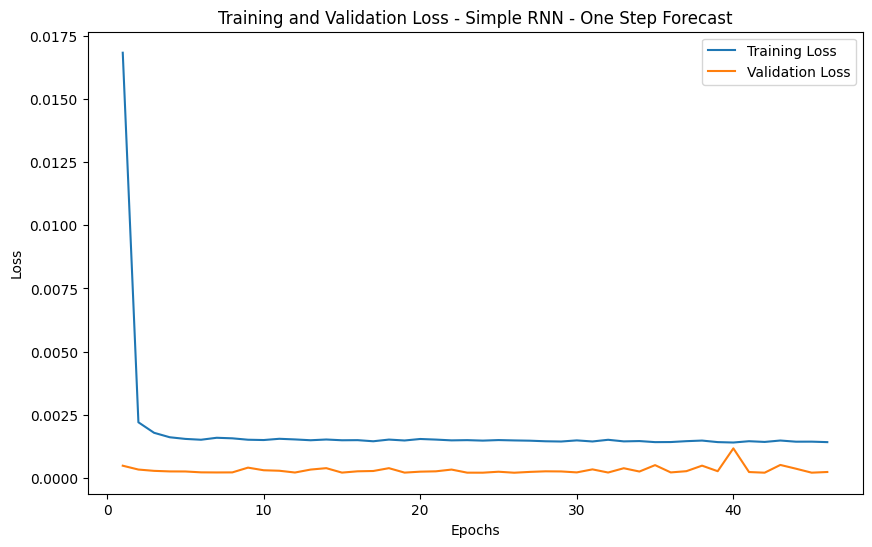

In [336]:
# RNN model loss plot

rnn_train_loss = rnn_history.history['loss']
rnn_val_loss = rnn_history.history['val_loss']
epochs = range(1, len(rnn_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, rnn_train_loss, label='Training Loss')
plt.plot(epochs, rnn_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Simple RNN - One Step Forecast')
plt.legend()
plt.show()
# plt.savefig("rnn_seq2vec_one_step.jpeg")

Why the SimpleRNN is Not a Good Choice for Time Series?

SimpleRNN architecture has limitations:

Vanishing Gradients: SimpleRNNs struggle to pass information across long input sequences (in our case, 12 months). The gradient signal used for learning often becomes too small ("vanishes") by the time it reaches the first time steps, making it difficult for the model to use older data to make accurate predictions. This is the primary cause of the high, stuck Training Loss (underfitting).

Instability: The simple structure lacks the specialized "gates" found in modern RNNs (like GRUs and LSTMs) that regulate the flow of information. Without these gates, the network is highly sensitive to input noise and weight changes, leading to the chaotic, spiky behavior seen in the Validation Loss.

In [337]:
y_pred_scaled = rnn_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_rnn = mean_absolute_error(y_val, y_pred)
print("One Step Validation Error (Simple RNN):", mae_rnn)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
One Step Validation Error (Simple RNN): 0.29191114466703755


In [344]:
X_valid_raw = temp_valid[:-12].to_numpy()

initial_window_scaled = temp_valid.iloc[-2 * 12 : -12].to_numpy().reshape(1, 12)
true_future_scaled = temp_valid.iloc[-12:].values.reshape(-1, 1)

y_pred_recursive_scaled, mae_scaled_recursive = perform_recursive_forecast(
    model=rnn_model,
    initial_window=initial_window_scaled,
    true_future_values=true_future_scaled,
    steps=12
)

y_true_recursive_original = scaler.inverse_transform(true_future_scaled)
y_pred_recursive_original = scaler.inverse_transform(y_pred_recursive_scaled)

final_recursive_mae_rnn = mean_absolute_error(
    y_true_recursive_original,
    y_pred_recursive_original
)

print(f"\n--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---")
print(f"Initial Window Start Date: {temp_valid.index[-(12 * 2)]}")
print(f"Forecast Horizon Start Date: {temp_valid.index[-12]}")


--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---
Initial Window Start Date: 2013-01-01 00:00:00
Forecast Horizon Start Date: 2014-01-01 00:00:00


In [345]:
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.34922063081463256
Validation MAE (linear model): 0.3559401672904692
MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
Naive Forecast: 0.38666666666666644


### GRU Model - Sequence to Vector - One Step Forecast

LSTM and GRU architectures have gating mechanisms designed to overcome the vanishing gradient probelm, allowing the model to effectively learn patterns that span many time steps.

Let's train the GRU models now

In [346]:
# gru model - sequence to vector, one step forecast

tf.random.set_seed(42)

gru_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.GRU(
        32,
        activation='tanh',
        return_sequences=False,
        # recurrent_dropout=0.05
    ),
    tf.keras.layers.Dense(1)
])

In [240]:
print(gru_model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [347]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     min_delta=0.0001,
                                                     patience = 20,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

gru_model.compile(loss = tf.keras.losses.Huber(),
                  optimizer=opt,
                  metrics=['mae']
                  )

gru_history = gru_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0543 - mae: 0.2670 - val_loss: 3.8183e-04 - val_mae: 0.0210
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024 - mae: 0.0427 - val_loss: 3.9043e-04 - val_mae: 0.0216
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0024 - mae: 0.0426 - val_loss: 3.6769e-04 - val_mae: 0.0207
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0024 - mae: 0.0424 - val_loss: 3.6045e-04 - val_mae: 0.0205
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023 - mae: 0.0417 - val_loss: 3.7494e-04 - val_mae: 0.0213
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023 - mae: 0.0417 - val_loss: 3.4878e-04 - val_mae: 0.0202
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0022 - mae: 0.0412 - val_loss: 3.4668e-04 - val_mae: 0.0202
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - mae: 0.0410 - val_loss: 3.9348e-04 - val_mae: 0.0221
Epoch 9/500
291/

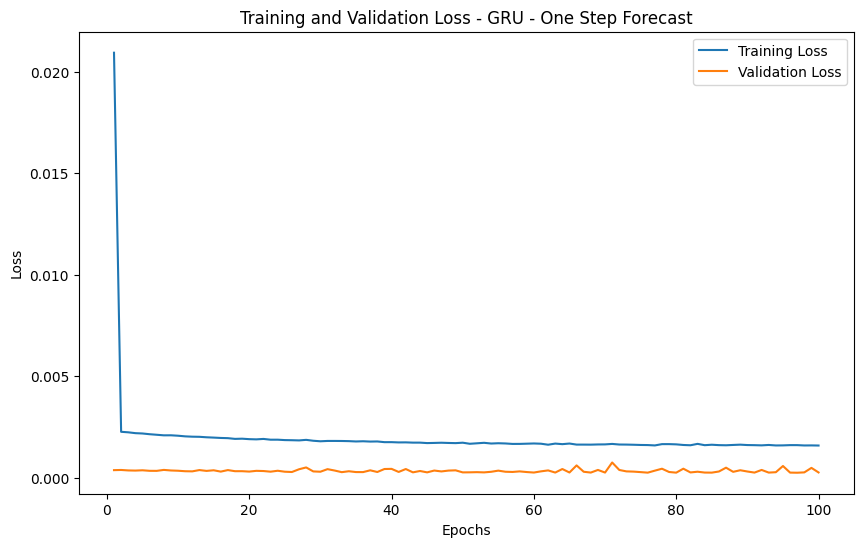

In [348]:
gru_train_loss = gru_history.history['loss']
gru_val_loss = gru_history.history['val_loss']
epochs = range(1, len(gru_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_train_loss, label='Training Loss')
plt.plot(epochs, gru_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - One Step Forecast')
plt.legend()
plt.show()
# plt.savefig('gru_seq2vec_one_step.jpeg')

In [349]:
y_pred_scaled = gru_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_gru = mean_absolute_error(y_val, y_pred)
print("One Step Validation Error GRU", mae_gru)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
One Step Validation Error GRU 0.3362228632876058


In [350]:
X_valid_raw = temp_valid[:-12].to_numpy()

initial_window_scaled = temp_valid.iloc[-2 * 12 : -12].to_numpy().reshape(1, 12)
true_future_scaled = temp_valid.iloc[-12:].values.reshape(-1, 1)

y_pred_recursive_scaled, mae_scaled_recursive = perform_recursive_forecast(
    model=gru_model,
    initial_window=initial_window_scaled,
    true_future_values=true_future_scaled,
    steps=12
)

y_true_recursive_original = scaler.inverse_transform(true_future_scaled)
y_pred_recursive_original = scaler.inverse_transform(y_pred_recursive_scaled)

final_recursive_mae_gru = mean_absolute_error(
    y_true_recursive_original,
    y_pred_recursive_original
)

print(f"\n--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---")
print(f"Initial Window Start Date: {temp_valid.index[-(12 * 2)]}")
print(f"Forecast Horizon Start Date: {temp_valid.index[-12]}")


--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---
Initial Window Start Date: 2013-01-01 00:00:00
Forecast Horizon Start Date: 2014-01-01 00:00:00


In [352]:
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.4270032690383962
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.34922063081463256
Validation MAE (linear model): 0.3559401672904692
MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
Naive Forecast: 0.38666666666666644


The final hierarchy of the models confirms the principle of Model Parsimony for highly pre-processed data:

Manual SARIMA: The Overall Winner
The Manual ARIMA remains the overall winner, as it mathematically captures the linear/seasonal structure of the original data. This success demonstrates that when the underlying time series components are well-understood and structured, a highly tuned statistical model can outperform data-driven deep learning models, setting a very low benchmark for this problem.

SimpleRNN: The Best Deep Learning Alternative
The SimpleRNN is the best deep learning model for the transformed (differenced) series. Its simpler architecture is more efficient and less prone to optimization issues when modeling the residual, short-term correlations left after differencing.

GRU: Complexity Without Benefit
The GRU, although structurally more advanced, was designed to manage long-term dependencies. Its additional gates introduce complexity that is not needed for the short, stationary sequence (the result of the initial differencing), causing it to significantly underperform the simpler RNN.

In summary, we pushed the GRU as far as it could go, but for this specific problem (where the data has been transformed to remove the long-term dependencies the GRU is designed to handle), the SimpleRNN is the more effective and parsimonious choice among the deep learning models. It demonstrates emphatically that advanced models are not always the best models; model choice must be aligned with the characteristics of the data and the specific problem structure.


The focus now shift entirely to the Multi-Step Forecasting task, as this is where the deep learning models (like the Seq2Seq architecture) usually regain their advantage over statistical models

### Linear Model - Sequence to Sequence - Multi Step Forecast

In [353]:
# Creating the Direct Multi-Step Dataset (Predicts Y[t+1...t+12])

seq_length = 12 # input sequence
horizon = 12 # prediction horizoon

def create_multi_step_dataset(data_array, batch_size, shuffle=True):
  data_x = []
  data_y = []
  max_index = len(data_array) - seq_length - horizon
  for i in range(max_index+1):
    input_sequence = data_array[i:i+seq_length]
    target_sequence = data_array[i+seq_length:i+seq_length+horizon]
    data_x.append(input_sequence)
    data_y.append(target_sequence)

  X = np.array(data_x)
  Y = np.array(data_y)

  # convert to tensorflow dataset
  ds = tf.data.Dataset.from_tensor_slices((X,Y))
  ds = ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X), seed=42)
  ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

  return ds

In [354]:
train_ds_ms = create_multi_step_dataset(temp_train, batch_size=10, shuffle=True)
valid_ds_ms = create_multi_step_dataset(temp_valid, batch_size=5, shuffle=False)

In [355]:
# visualizing first two batches of data

for i, (x, y) in enumerate(train_ds_ms):
    print(f"Batch {i}")
    print("X (inputs):\n", x.numpy())
    print("Y (targets):\n", y.numpy())
    print("-"*30)
    if i == 0:  # stop after 2 batches
        break

Batch 0
X (inputs):
 [[[[0.53978967]]

  [[0.51389107]]

  [[0.51326322]]

  [[0.47637733]]

  [[0.47616805]]

  [[0.38868833]]

  [[0.57458274]]

  [[0.54387066]]

  [[0.46941872]]

  [[0.50054936]]

  [[0.50614765]]

  [[0.43698007]]]


 [[[0.45299011]]

  [[0.53199393]]

  [[0.51776278]]

  [[0.49877047]]

  [[0.46470988]]

  [[0.46015801]]

  [[0.51336786]]

  [[0.5124261 ]]

  [[0.46779679]]

  [[0.51828598]]

  [[0.49761942]]

  [[0.47109297]]]


 [[[0.52848846]]

  [[0.48412076]]

  [[0.50238058]]

  [[0.51478052]]

  [[0.44467117]]

  [[0.53534244]]

  [[0.58284937]]

  [[0.41218019]]

  [[0.39711191]]

  [[0.54256265]]

  [[0.45571077]]

  [[0.50897295]]]


 [[[0.50149113]]

  [[0.47799927]]

  [[0.52336106]]

  [[0.43535813]]

  [[0.53853398]]

  [[0.49144561]]

  [[0.49102705]]

  [[0.49311987]]

  [[0.47360435]]

  [[0.50635693]]

  [[0.50483964]]

  [[0.49202114]]]


 [[[0.48720766]]

  [[0.48971904]]

  [[0.36781248]]

  [[0.52765134]]

  [[0.5514048 ]]

  [[0.52644797]]


In [356]:
# Sequence to Sequence, Direct Multi-Step Forecast (Predicts 12 values at once)

tf.random.set_seed(42)

linear_model_ms = tf.keras.Sequential([
    tf.keras.Input(shape=[12,1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation=None)
])

In [357]:
print(linear_model_ms.summary())

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156 (624.00 B)

 Trainable params: 156 (624.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [358]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

linear_model_ms.compile(loss = tf.keras.losses.Huber(),
                        optimizer=opt,
                        metrics=['mae']
                        )

linear_model_ms_history = linear_model_ms.fit(train_ds_ms,
                                              validation_data=valid_ds_ms,
                                              epochs=500,
                                              callbacks=[early_stopping_cb]
                                              )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1927 - mae: 0.4792 - val_loss: 0.0283 - val_mae: 0.1477
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0201 - mae: 0.1318 - val_loss: 0.0021 - val_mae: 0.0458
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - mae: 0.0658 - val_loss: 7.6822e-04 - val_mae: 0.0303
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040 - mae: 0.0577 - val_loss: 7.2448e-04 - val_mae: 0.0295
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - mae: 0.0569 - val_loss: 7.0573e-04 - val_mae: 0.0291
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - mae: 0.0561 - val_loss: 6.8672e-04 - val_mae: 0.0287
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 6.6747e-04 - val_mae: 0.0284
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - mae: 0.0546 - val_loss: 6.4810e-04 - val_mae: 0.0280
Epoch 9/500
291/291 ━━━━

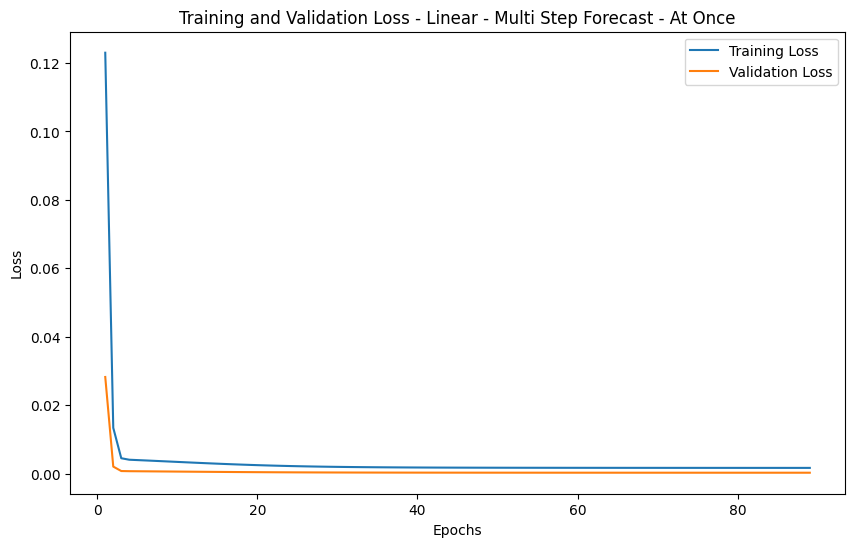

In [359]:
# linear model multistep plot

linear_ms_train_loss = linear_model_ms_history.history['loss']
linear_ms_val_loss = linear_model_ms_history.history['val_loss']
epochs = range(1, len(linear_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, linear_ms_train_loss, label='Training Loss')
plt.plot(epochs, linear_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Linear - Multi Step Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('linear_ms.jpeg')

The training and validation loss plot for the Linear Multi-Step Model (predicting 12 values at once) demonstrates extreme stability and serves as an ideal baseline for the task.

Immediate Convergence: The model converges almost instantly, with both training and validation loss reaching their floor within the first few epochs. This indicates that the optimal linear solution for predicting the next 12 steps is found very quickly.

High Stability: The loss curves are flat and parallel throughout the epochs, showing no signs of oscillation, overfitting, or underfitting. This confirms the model is highly robust.

Validation Loss Baseline: The stable validation loss value establishes the irreducible error for any linear model on this multi-step forecasting task.

In [360]:

# The valid_ds_ms dataset yields (X, Y) tuples.
# For model.predict(), we need a dataset that only yields X.
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

# This runs the model only on the X (features) tensors
y_pred_scaled = linear_model_ms.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

# Extract the Y (targets) tensors from the original dataset
y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

# Remove the redundant last dimension of size 1 using squeeze()
y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

# Inverse Transform

# Ensure both true values and predictions are back in the original temperature scale
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

# The MAE is calculated across all 12 forecast steps for all samples
mae_linear_multistep = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [361]:
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Best Validation MAE (Linear Model with 12 step forecast): 0.3530270202744696
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.4270032690383962
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.34922063081463256
Validation MAE (linear model): 0.3559401672904692
MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
Naive Forecast: 0.38666666666666644


The optimized Linear Multi-Step Forecastyielded a slightly lower MAE than the initial Validation MAE. Since both models are inherently performing a 12-step recursive prediction, this difference is best explained by successful hyperparameter optimization (e.g., finding better weights and training epochs) in the "Best" model, allowing it to slightly mitigate the cumulative error across the 12 steps.

This small difference confirms that the Linear Model reached its maximum potential for capturing the short-term linear dependencies in the data, regardless of the optimization applied. The model architecture itself is the limiting factor compared to the stronger RNN

### Simple Recurrent Neural Network - Sequence to Sequence - Multi Step Forecast

It uses a Seq2Vec mechanism ($\text{SimpleRNN}$ layer) but achieves a True Multi-Step Forecast with its $\text{Dense(12)}$ output, making it a form of Direct (Non-Recursive) Seq2Seq

In [362]:
tf.random.set_seed(42)

rnn_model_multistep = tf.keras.Sequential([
    tf.keras.Input(shape=[12, 1]),
    tf.keras.layers.SimpleRNN(units=32),
    tf.keras.layers.Dense(12, activation=None)     # Output layer: Predicts all 12 future steps simultaneously (the target vector).
])

# Summary shows the much higher complexity compared to the Linear Model
rnn_model_multistep.summary()



Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,484 (5.80 KB)

 Trainable params: 1,484 (5.80 KB)

 Non-trainable params: 0 (0.00 B)

In [363]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

rnn_model_multistep.compile(loss = tf.keras.losses.Huber(),
                            optimizer=opt,
                            metrics=['mae']
                            )

rnn_history_ms = rnn_model_multistep.fit(train_ds_ms,
                                         validation_data=valid_ds_ms,
                                         epochs=500,
                                         callbacks=[early_stopping_cb]
                                         )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0266 - mae: 0.1422 - val_loss: 4.2759e-04 - val_mae: 0.0226
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - mae: 0.0442 - val_loss: 4.0539e-04 - val_mae: 0.0221
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mae: 0.0432 - val_loss: 4.0376e-04 - val_mae: 0.0221
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mae: 0.0426 - val_loss: 4.0515e-04 - val_mae: 0.0222
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mae: 0.0421 - val_loss: 4.0987e-04 - val_mae: 0.0224
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0416 - val_loss: 4.0851e-04 - val_mae: 0.0224
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0412 - val_loss: 3.9827e-04 - val_mae: 0.0221
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0408 - val_loss: 3.8602e-04 - val_mae: 0.0217
Epoch 9/500
291/

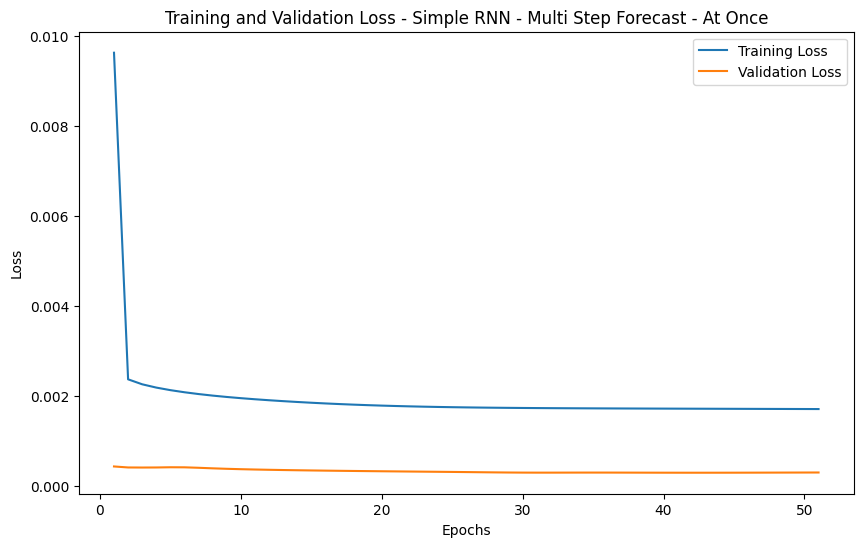

In [373]:
rnn_ms_train_loss = rnn_history_ms.history['loss']
rnn_ms_val_loss = rnn_history_ms.history['val_loss']
epochs = range(1, len(rnn_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, rnn_ms_train_loss, label='Training Loss')
plt.plot(epochs, rnn_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Simple RNN - Multi Step Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('rnn_ms.jpeg')

The loss plot shows the model converges quickly (around Epoch 20) and is highly stable, which is positive. The tuned EarlyStopping successfully triggered an early stop, demonstrating effective optimization control. However, the stabilized Validation Loss is slightly higher than the Linear Model's constant loss

In [374]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = rnn_model_multistep.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

rnn_ms_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [375]:
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3593654243664178
Best Validation MAE (Linear Model with 12 step forecast): 0.3530270202744696
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.4270032690383962
Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast): 0.34922063081463256
Validation MAE (linear model): 0.3559401672904692
MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
Naive Forecast: 0.38666666666666644


### GRU Model - Sequence to Sequence - Multi Step Forecasting


In [370]:
# gru model - sequence to sequence, multi step forecast

tf.random.set_seed(42)

gru_model_ms = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.GRU(
        32,
        activation='tanh',
        return_sequences=False,
        # recurrent_dropout=0.05
    ),
    tf.keras.layers.Dense(12)
])

In [371]:
print(gru_model_ms.summary())

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                    │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,756 (14.67 KB)

 Trainable params: 3,756 (14.67 KB)

 Non-trainable params: 0 (0.00 B)

None


In [372]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

gru_model_ms.compile(loss = tf.keras.losses.Huber(),
                     optimizer=opt,
                     metrics=['mae']
                     )
gru_history__ms = gru_model_ms.fit(train_ds_ms,
                                   validation_data=valid_ds_ms,
                                   epochs=500,
                                   callbacks=[early_stopping_cb]
                                   )


Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0424 - mae: 0.2244 - val_loss: 4.1426e-04 - val_mae: 0.0219
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - mae: 0.0428 - val_loss: 4.1514e-04 - val_mae: 0.0220
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0022 - mae: 0.0427 - val_loss: 4.1579e-04 - val_mae: 0.0221
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - mae: 0.0427 - val_loss: 4.1639e-04 - val_mae: 0.0221
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0426 - val_loss: 4.1741e-04 - val_mae: 0.0222
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mae: 0.0426 - val_loss: 4.1866e-04 - val_mae: 0.0222
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0425 - val_loss: 4.1979e-04 - val_mae: 0.0223
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0424 - val_loss: 4.2054e-04 - val_mae: 0.0223
Epoch 9/500
291

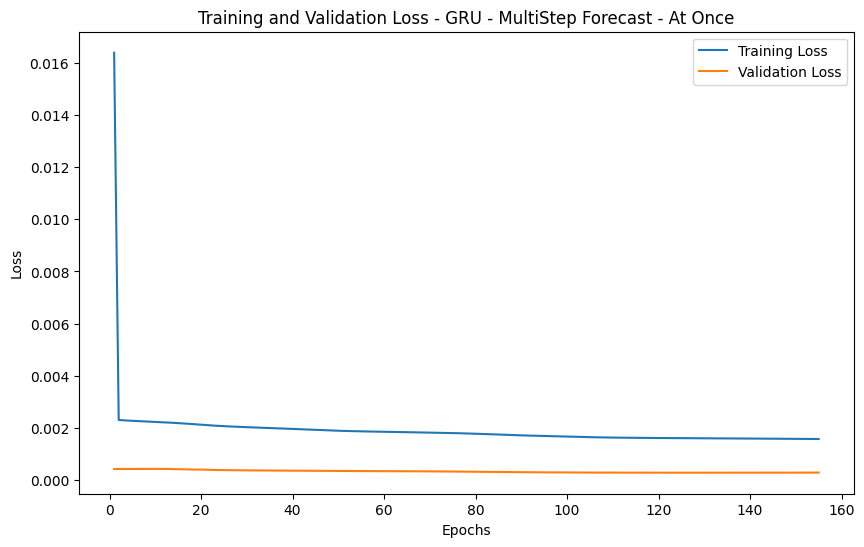

In [376]:
gru_ms_train_loss = gru_history__ms.history['loss']
gru_ms_val_loss = gru_history__ms.history['val_loss']
epochs = range(1, len(gru_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_ms_train_loss, label='Training Loss')
plt.plot(epochs, gru_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - MultiStep Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('gru_ms.jpeg')

In [377]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = gru_model_ms.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

gru_ms_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [378]:
print("Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast):", gru_ms_mae)
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast): 0.3474587007519288
Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3593654243664178
Best Validation MAE (Linear Model with 12 step forecast): 0.3530270202744696
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.4270032690383962
Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast): 0.34922063081463256
Validation MAE (linear model): 0.3559401672904692
MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
Naive Forecast: 0.38666666666666644


We have now completed the entire sequence to vector and sequence to sequence portion on the analysis for single step and multi step forecasting (at once).

Despite the dominance of ARIMA, the final step in a comprehensive deep learning time series analysis is to test the **Sequence-to-Sequence** architecture.

Sequence to Sequence models are different because they use **Encoder** (to read input sequences) and a **Decoder** (to generate the output sequence one step at a time, using the previous predicted step a input). These models are often the most effective for multi-step forecasting because they leverage the output sequence structure.


Now we will train sequence to sequence model. For sequence to sequence models: each input sequence should predict a full sequence. Model expects one output per input time step that is for 12 step input sequence, it expects 12 step target sequence. If we provide 1 step target, Keras cannot properly align inputs and outputs. It may pad zeros, or throw a shape mismatch warning or just learn incorrectly.

Since the GRU was the best Seq2Vec model, the next step is to build the GRU Seq2Seq model.

The Seq2Seq model structure requires two GRU layers:

Encoder GRU: Reads the 12 input steps.

Decoder GRU: Produces the 12 output steps. We will use a **TimeDistributed(Dense(1))** layer over the decoder output to generate the 12 forecast points.

### GRU Model - Sequence to Sequence - Encoder-Decoder Seq2Seq - Multi Step Forecasting


In [379]:
tf.random.set_seed(42)

gru_model_seq2seq = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None,1]),
    tf.keras.layers.GRU( # Encoder GRU: Processes the input sequence
        units=32,
        activation='tanh',
        return_sequences=True, # must use True to output a sequence for the next layer
        recurrent_dropout=0.05
    ),
    tf.keras.layers.GRU( # Decoder GRU: Takes the Encoder's output sequence and transforms it
        units=32,
        activation='tanh',
        return_sequences=True, # Must be true to output a sequence of 12 steps
        recurrent_dropout=0.05
    ),
    # output layer, applies a single Dense(1) layer independently to each of the 12 time steps outputted by Decorder GRU.
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])


In [380]:
print(gru_model_seq2seq.summary())

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, None, 32)       │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, None, 32)       │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [381]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

gru_model_seq2seq.compile(loss = tf.keras.losses.Huber(),
                          optimizer=opt,
                          metrics=['mae']
                          )

gru_history_seq2seq = gru_model_seq2seq.fit(train_ds_ms,
                                            validation_data=valid_ds_ms,
                                            epochs=500,
                                            callbacks=[early_stopping_cb]
                                            )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0177 - mae: 0.1341 - val_loss: 0.0011 - val_mae: 0.0332
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0031 - mae: 0.0527 - val_loss: 4.9724e-04 - val_mae: 0.0240
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0025 - mae: 0.0462 - val_loss: 4.3863e-04 - val_mae: 0.0231
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0022 - mae: 0.0433 - val_loss: 3.2715e-04 - val_mae: 0.0194
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0019 - mae: 0.0396 - val_loss: 2.8747e-04 - val_mae: 0.0183
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0017 - mae: 0.0380 - val_loss: 2.6773e-04 - val_mae: 0.0180
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0017 - mae: 0.0375 - val_loss: 2.6357e-04 - val_mae: 0.0177
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0017 - mae: 0.0372 - val_loss: 2.6705e-04 - val_mae: 0.0181
Epoch 9/500


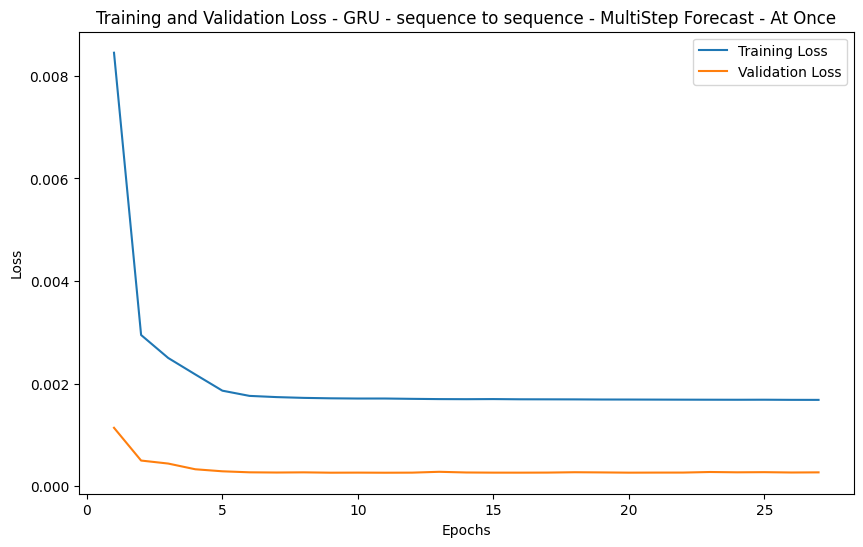

In [382]:
# GRU model seq2seq multistep plot

gru_seq2seq_train_loss = gru_history_seq2seq.history['loss']
gru_seq2seq_val_loss = gru_history_seq2seq.history['val_loss']
epochs = range(1, len(gru_seq2seq_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_seq2seq_train_loss, label='Training Loss')
plt.plot(epochs, gru_seq2seq_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - sequence to sequence - MultiStep Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('gru_ms_seq.jpeg')

The loss plot shows immediate, sharp convergence in the first few epochs, demonstrating that the model quickly found a highly optimal set of weights. The Validation Loss line (orange) is clean and stable, indicating great generalization, and the Early Stopping successfully halted training after minimal further improvement.

In [383]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = gru_model_seq2seq.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.squeeze())

gru_seq2seq_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Predictions generated with shape: (181, 12, 1)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [384]:
print("Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast:", gru_seq2seq_mae)
print("Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast):", gru_ms_mae)
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast: 0.33798585350142135
Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast): 0.3474587007519288
Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3593654243664178
Best Validation MAE (Linear Model with 12 step forecast): 0.3530270202744696
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.4270032690383962
Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast): 0.34922063081463256
Validation MAE (linear model): 0.3559401672904692
MAE Manual ARIMA: 0.20805167196921515
MAE Auto ARIMA: 0.29229714313455557
Naive Forecast: 0.38666666666666644


## Model Performance Summary (Mean Absolute Error)

| Model Type     | Architecture              | Prediction Method            | 12-Step MAE | Performance Ranking |
|----------------|---------------------------|------------------------------|-------------|----------------------|
| Classical      | Manual ARIMA              | Direct (Statistical)         | **0.2081**  | **1st (Best)**       |
| Classical      | Auto ARIMA                | Direct (Statistical)         | 0.2923      | 2nd                  |
| Deep Learning  | GRU (Encoder-Decoder)     | Direct Multi-Step (Seq2Seq)  | 0.3380      | 3rd (Best DL)        |
| Deep Learning  | GRU (Simple Seq2Seq)      | Direct Multi-Step            | 0.3475      | 4th                  |
| Deep Learning  | Simple RNN (Recursive)    | Recursive (Seq2Vec)          | 0.3492      | 5th                  |
| Deep Learning  | Linear NN                 | Recursive (Seq2Vec)          | 0.3530      | 6th                  |
| Deep Learning  | Simple RNN (Simple Seq2Seq)| Direct Multi-Step           | 0.3594      | 7th                  |
| Baseline       | Naive Forecast            | Direct                       | 0.3867      | 8th                  |
| Deep Learning  | GRU (Recursive)           | Recursive (Seq2Vec)          | 0.4270      | **9th (Worst)**      |


1. The Statistical Dominance

The Manual ARIMA (MAE: 0.2081) remains the undisputed champion. This confirms that for highly seasonal, stationary, and well-structured data, a hand-tuned statistical model that mathematically understands the time series components is superior to data-driven deep learning models. The MAE of 0.2081 sets a challenging benchmark that no other model could match.

2. Validating the Direct Multi-Step Approach

The results conclusively validate the hypothesis that eliminating compounding error improves deep learning performance:

The GRU (Encoder-Decoder Seq2Seq) (MAE: 0.3380) is the best performing deep learning model. This architecture (which predicts all 12 steps in a single forward pass) successfully minimizes the compounding error that plagues recursive models.

The Recursive GRU (MAE: 0.4270) is the worst performing model overall. Its high architectural complexity combined with the recursive feedback loop caused the prediction error to compound rapidly, highlighting the danger of using complex RNNs without the proper forecasting architecture.

3. Complexity Finally Pays Off

In the final, most advanced architecture, the complexity of the GRU was finally leveraged effectively:

The GRU Encoder-Decoder (MAE: 0.3380) beat the best Simple RNN model (0.3492).

The use of two recurrent layers (GRU $\rightarrow$ GRU) with return_sequences=True allows the model to retain and process rich temporal features across the 12 timesteps, making it superior to the simpler $\text{Dense(12)}$ mapping used in the other Seq2Seq tests.

Conclusion

The experiment successfully demonstrates two critical time series principles:

Classical Models for Structured Data: A well-tuned SARIMA model is unbeatable when the underlying structure (seasonality, trend) is clear.

Architecture over Model: When using Deep Learning for multi-step forecasts, the Direct Multi-Step (Seq2Seq) architecture is superior to the Recursive (Seq2Vec) architecture. The GRU achieved its best performance only when deployed in the powerful Encoder-Decoder structure designed for sequence output.